# Advanced geometry component concepts: Exit geometry and number of activations
This notebook explains the concept of exit geometry and the activation counter both of which are tied to the geometry components and how they are treated by the *Union_master*.

An exit geometry is created by setting the *material_string* of a geometry to "Exit", and if a ray enters such a geometry, it is immediately released from the master component. Normally this only happens when the ray does not intersect any geometries. There are several uses for this, for example inserting a monitor within a Union geometry ensemble.

In [1]:
from mcstasscript.interface import instr, functions, plotter

### Set up an example with empty sample container
First we set up an example with an empty sample container.

In [2]:
instrument = instr.McStas_instr("python_tutorial", input_path="run_folder")

In [3]:
Al_inc = instrument.add_component("Al_inc", "Incoherent_process")
Al_inc.sigma = 0.0082
Al_inc.unit_cell_volume = 66.4

Al_pow = instrument.add_component("Al_pow", "Powder_process")
Al_pow.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_inc,Al_pow"'
Al.my_absorption = 100*0.231/66.4 # barns [m^2 E-28]*Å^3 [m^3 E-30]=[m E-2], factor 100

src = instrument.add_component("source", "Source_div")
src.xwidth = 0.01
src.yheight = 0.035
src.focus_aw = 0.01
src.focus_ah = 0.01
src.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                       comment="Wavelength in [Ang]")
src.dlambda = "0.01*wavelength"
src.flux = 1E13

sample_volume = instrument.add_component("sample_volume", "Union_cylinder")
sample_volume.yheight = 0.03
sample_volume.radius = 0.0075
sample_volume.material_string='"Vacuum"' 
sample_volume.priority = 100
sample_volume.set_AT([0,0,1], RELATIVE=src)

container = instrument.add_component("sample_container", "Union_cylinder")
container.set_RELATIVE(sample_volume)
container.yheight = 0.03+0.003 # 1.5 mm top and button
container.radius = 0.0075 + 0.0015 # 1.5 mm sides of container
container.material_string='"Al"' 
container.priority = 99

container_lid = instrument.add_component("sample_container_lid", "Union_cylinder")
container_lid.set_AT([0, 0.0155, 0], RELATIVE=container)
container_lid.yheight = 0.004
container_lid.radius = 0.013
container_lid.material_string='"Al"' 
container_lid.priority = 98

inner_wall = instrument.add_component("cryostat_wall", "Union_cylinder")
inner_wall.set_AT([0,0,0], RELATIVE=sample_volume)
inner_wall.yheight = 0.12
inner_wall.radius = 0.03
inner_wall.material_string='"Al"' 
inner_wall.priority = 80

inner_wall_vac = instrument.add_component("cryostat_wall_vacuum", "Union_cylinder")
inner_wall_vac.set_AT([0,0,0], RELATIVE=sample_volume)
inner_wall_vac.yheight = 0.12 - 0.008
inner_wall_vac.radius = 0.03 - 0.002
inner_wall_vac.material_string='"Vacuum"' 
inner_wall_vac.priority = 81

logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space")
logger_zx.set_RELATIVE(sample_volume)
logger_zx.D_direction_1 = '"z"'
logger_zx.D1_min = -0.04
logger_zx.D1_max = 0.04
logger_zx.n1 = 300
logger_zx.D_direction_2 = '"x"'
logger_zx.D2_min = -0.04
logger_zx.D2_max = 0.04
logger_zx.n2 = 300
logger_zx.filename = '"logger_zx.dat"'

logger_zy = instrument.add_component("logger_space_zy", "Union_logger_2D_space")
logger_zy.set_RELATIVE(sample_volume)
logger_zy.D_direction_1 = '"z"'
logger_zy.D1_min = -0.04
logger_zy.D1_max = 0.04
logger_zy.n1 = 300
logger_zy.D_direction_2 = '"y"'
logger_zy.D2_min = -0.06
logger_zy.D2_max = 0.06
logger_zy.n2 = 300
logger_zy.filename = '"logger_zy.dat"'

master = instrument.add_component("master", "Union_master")

banana = instrument.add_component("banana", "Monitor_nD", RELATIVE=sample_volume)
banana.xwidth = 1.5
banana.yheight = 0.4
banana.restore_neutron = 1
banana.options = '"theta limits=[5 175] bins=250, banana"'

In [4]:
instrument.set_parameters(wavelength=3.0)
instrument.settings(ncount=3E6, output_path="data_folder/union_external")

data_empty = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_external_91"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


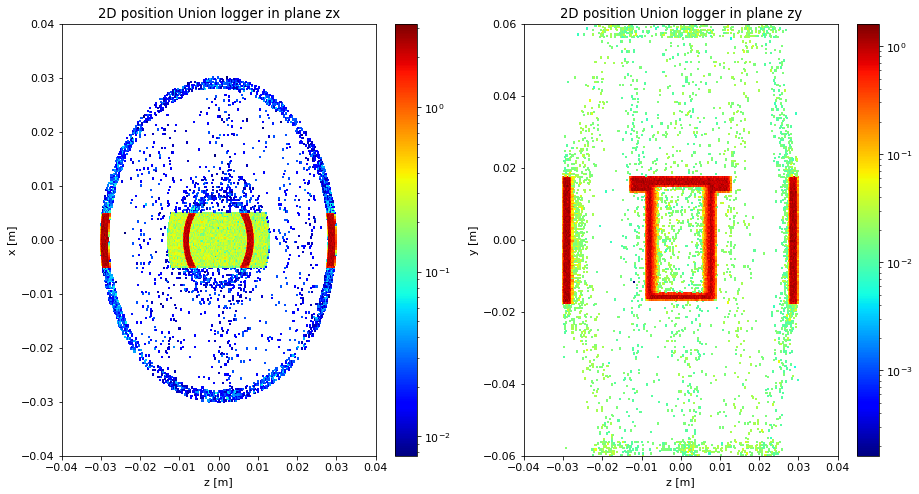

Plotting data with name banana


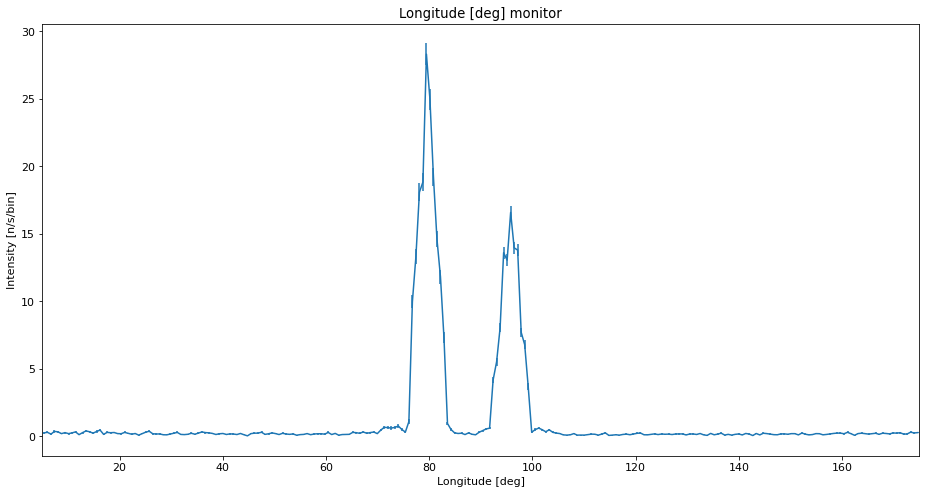

In [5]:
functions.name_plot_options("logger_space_zx", data_empty, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data_empty, log=True, orders_of_mag=4)
plotter.make_sub_plot(data_empty[0:2])
plotter.make_sub_plot(data_empty[2])

## Adding an exit volume
Now we switch the sample_volume material from Vacuum to exit, ejecting rays from the simulation when they encounter it.

In [6]:
sample_volume.material_string='"Exit"' 

In [7]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_external_92"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


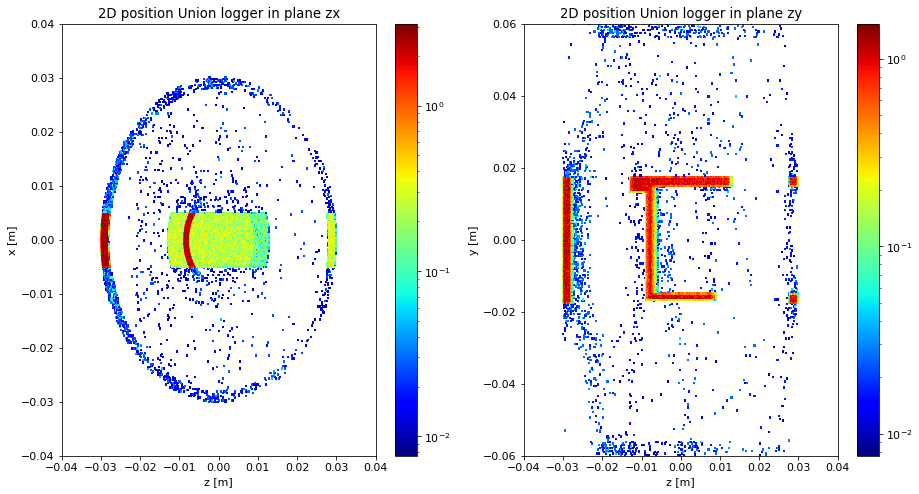

Plotting data with name banana


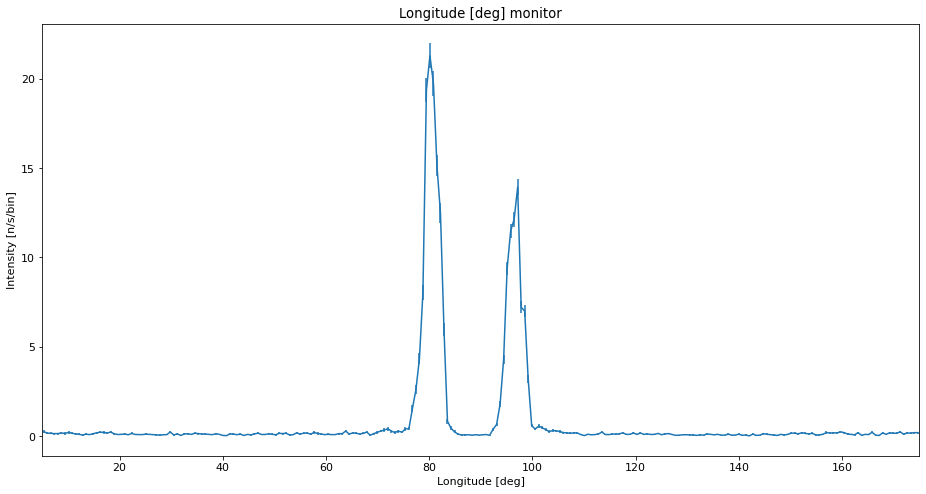

In [8]:
functions.name_plot_options("logger_space_zx", data, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data, log=True, orders_of_mag=4)
plotter.make_sub_plot(data[0:2])
plotter.make_sub_plot(data[2])

### Adding an external component in the gap
We can now see any part of the beam that intersected the exit volume is basically removed from the simulation. It is now however possible to insert another component within that exit volume, for example a sample not available as a Union process. Here we just use a PowderN sample in order to demonstrate. We select the same dimensions as the exit volume, but subtract 10 micrometer to avoid a perfect overlap.

In [9]:
sample = instrument.add_component("sample", "PowderN", after="master")
sample.set_AT([0,0,0], RELATIVE=sample_volume)
sample.radius = sample_volume.radius - 1E-5
sample.yheight = sample_volume.yheight - 2E-5
sample.reflections = '"Na2Ca3Al2F14.laz"'

### Running the simulation again
We run the simulation again, but know that the scattering within the sample wont be directly visible in the loggers.

In [10]:
data_wrong = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_external_93"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


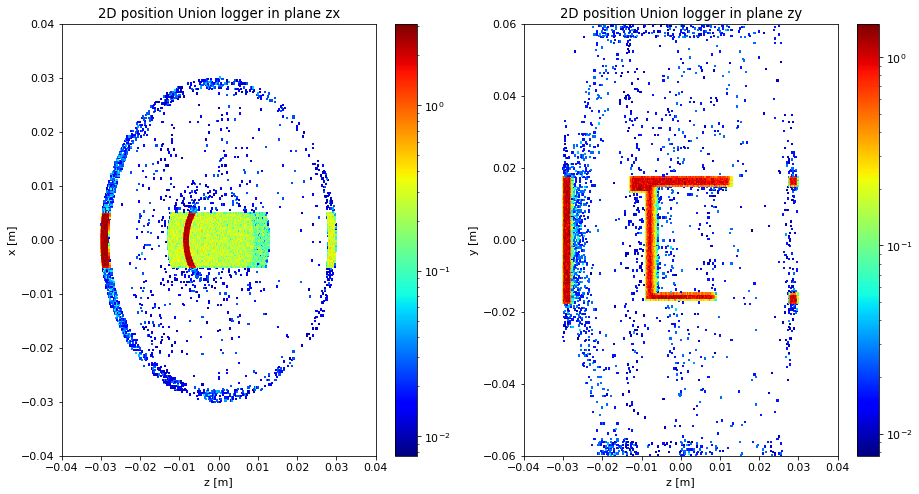

Plotting data with name banana


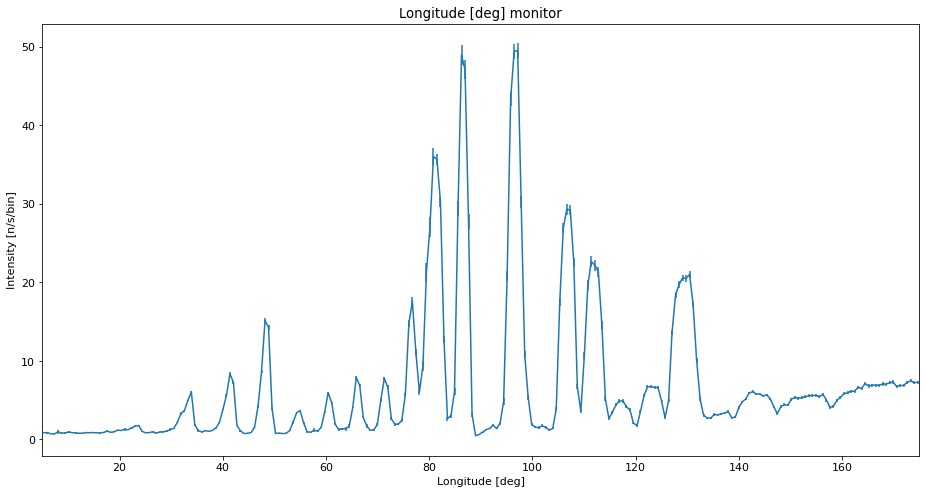

In [11]:
functions.name_plot_options("logger_space_zx", data_wrong, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data_wrong, log=True, orders_of_mag=4)
plotter.make_sub_plot(data_wrong[0:2])
plotter.make_sub_plot(data_wrong[2])

### Interpretation of the data
Now we have added a sample inside the Union geometry, but when the neutron reaches that sample, it is ignored by the sample environment leading to unphysical behavior. Here the beam does not illuminate the sample environment on the way out, and all rays scattered by the PowderN sample are not attenuated by the 

## Allowing the rays to return to the Union_master
Now we could recreate the entire sample environment with new geometries and insert an additional unit master to grab the neutrons after the external sample, yet this would be error prone as all geometries would need to be exactly the same. Instead it is possible to tell Union geometries that they should be simulated in several of the next *Union_master* components using the *number_of_activation* parameter on each Union geometry, which is 1 per default.

Setting it to 2, we tell the geometries that they should be simulated in the two next *Union_master* components. We do not update the sample_volume which is an exit volume, as this would allow the ray to escape once more. Instead we will replace it with Vacuum, but one could also have placed something closer to the actual sample.

One last necessary detail is to set the *allow_inside_start* parameter on the second *Union_master* component. This disables an error message that would occur if a neutron starts inside a Union geometry, as this is most likely an error. Here we want to do this on purpose, and we need to let the *Union_master* component know this is allowed.

In [12]:
container.number_of_activations = 2
container_lid.number_of_activations = 2
inner_wall.number_of_activations = 2
inner_wall_vac.number_of_activations = 2

sample_replacement = instrument.add_component("sample_volume_replace", "Union_cylinder")
sample_replacement.yheight = sample_volume.yheight
sample_replacement.radius = sample_volume.radius
sample_replacement.material_string='"Vacuum"' 
sample_replacement.priority = 101
sample_replacement.set_AT([0,0,0], RELATIVE=sample_volume)

master_2 = instrument.add_component("master_after_sample", "Union_master", after="sample")
master_2.allow_inside_start=1

In [13]:
data = instrument.backengine()

INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript/docs/source/tutorial/data_folder/union_external_94"
INFO: Regenerating c-file: python_tutorial.c
CFLAGS= -I@MCCODE_LIB@/share/
INFO: Recompiling: ./python_tutorial.out
mccode-r.c:2837:3: warning: expression result unused [-Wunused-value]
  *t0;
  ^~~
In file included from /Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//contrib/union/Incoherent_process.comp:65:
/Applications/McStas-2.7.1.app/Contents/Resources/mcstas/2.7.1//share/Union_functions.c:1604:105: warning: incompatible pointer types passing 'int (const struct saved_history_struct *, const struct saved_history_struct *)' to parameter of type 'int (* _Nonnull)(const void *, const void *)' [-Wincompatible-pointer-types]
  qsort(total_history.saved_histories,total_history.used_elements,sizeof (struct saved_history_struct), Sample_compare_history_intensities);
                                                                         

Plotting data with name logger_space_zx
Plotting data with name logger_space_zy


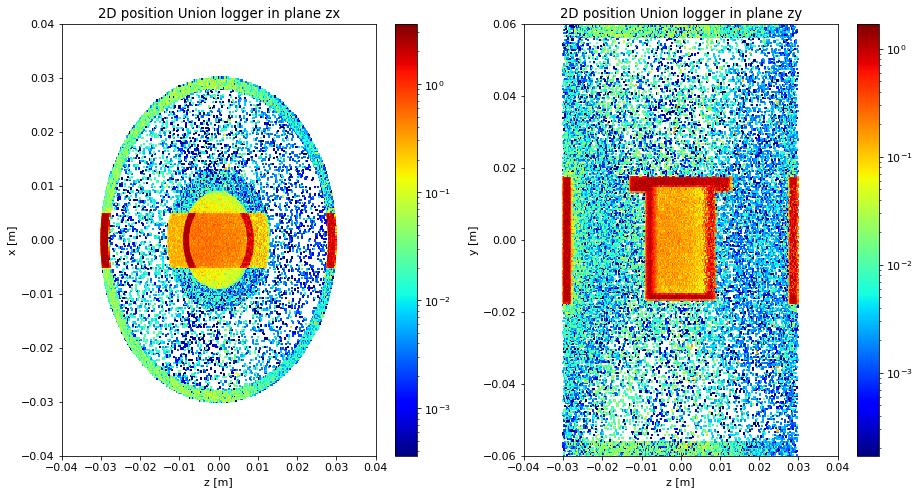

Plotting data with name banana


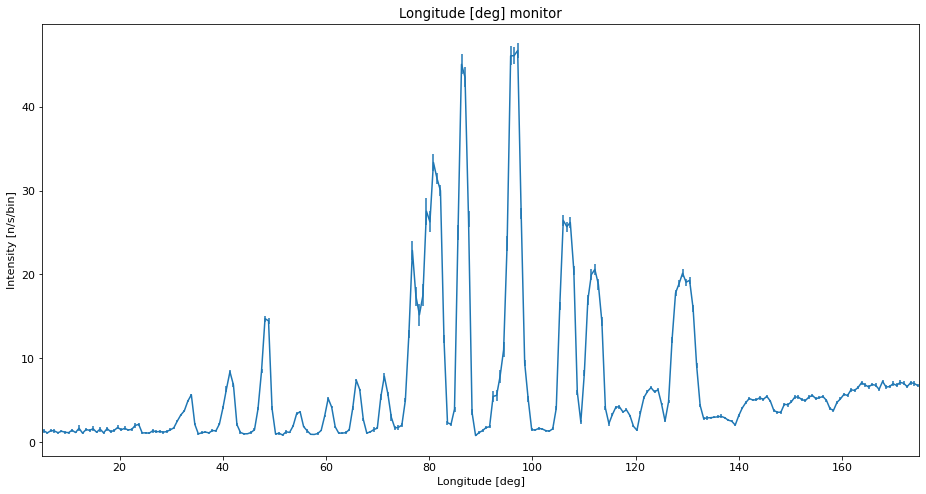

In [14]:
functions.name_plot_options("logger_space_zx", data, log=True, orders_of_mag=4)
functions.name_plot_options("logger_space_zy", data, log=True, orders_of_mag=4)
plotter.make_sub_plot(data[0:2])
plotter.make_sub_plot(data[2])

### Interpretation of the data
Now we see evidence of the beam leaving the sample environment after interacting with the sample, and also elevated scattering in comparison to the empty can. This is now a reasonable simulation containing an external component inside a Union geometry ensemble, but there is still one problem, if the ray leaves the external component and reenters later, it will find a Vacuum instead of that sample. This can be fixed to some extend by adding a second copy of the external component and a third *Union_master* component, while incrementing the *number_of_activations* on all geometries, then the ray would be able to leave and enter the external component once before the external component effectively disappears. Even with this assumption, it is still a reasonable approximation and a flexible approach to add for example a mirror inside a sample environment.

## Comparison of the three datasets
Here we compare the three datasets, the empty sample environment, the wrong simulation where rays scattered in the sample could not interact with the sample environment, and the full simulation.

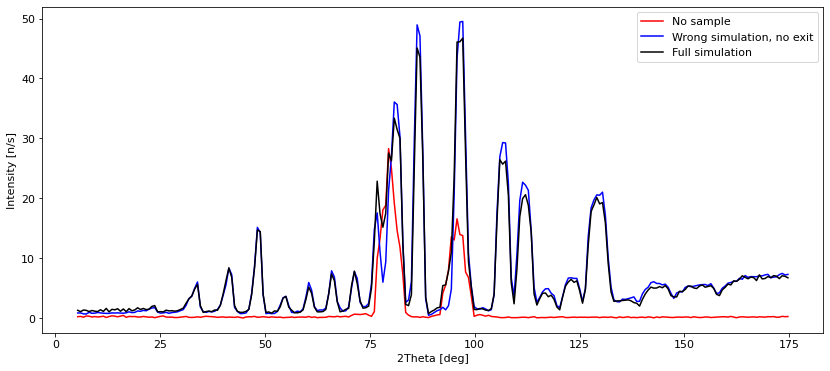

In [15]:
banana_empty = functions.name_search("banana", data_empty)
banana_wrong = functions.name_search("banana", data_wrong)
banana_sample = functions.name_search("banana", data)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(banana_empty.xaxis, banana_empty.Intensity, "r",
         banana_wrong.xaxis, banana_wrong.Intensity, "b",
         banana_sample.xaxis, banana_sample.Intensity, "k")
plt.xlabel("2Theta [deg]")
plt.ylabel("Intensity [n/s]")
plt.legend(["No sample", "Wrong simulation, no exit", "Full simulation"])

### Interpretation of the data
We see that the wrong simulation have slightly lower background, and more peak intensity. We also see the peak shape is different near the aluminium Bragg peaks. Since the Union components contain a powder process, one can also recreate this example without using an external PowderN component to check the accuracy of the approach. It is however still not perfect, as the Union powder process will perform multiple scattering where PowderN will not. 